In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.algorithms import NumPyEigensolver
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

In [2]:
from catalyst import cond, measure, for_loop, qjit
import jax; jax.config.update('jax_platform_name', 'cpu')
from jax import numpy as jnp
from jax import random

## Helper functions

In [3]:
n_shots = 100

In [4]:
def measure_and_reset(wire):
    """
    Measure a wire and then reset it back to the |0⟩ state.
    """

    m = measure(wire)

    @cond(m)
    def conditional_flip():
        qml.PauliX(wires=wire)

    conditional_flip()

    return m

def conditional_update_for_counters(pred, m1):
    
    @cond(pred)
    def conditional_fn():
        # when the predicate is true
        return (m1 == 0).astype(int), (m1 == 1).astype(int), (m1 != 5).astype(int), (m1 != 5).astype(int)

    @conditional_fn.otherwise
    def conditional_fn():
        return (m1 == 5).astype(int), (m1 == 5).astype(int), (m1 == 5).astype(int), (m1 == 5).astype(int)
    
    return conditional_fn()  # must invoke the defined function

def conditional_parameterized_unitary(pred, params, num_qubits):
    """Conditionally perform unitary operation based on a predicate"""
    
    # code to be executed over index i starting
    # from lower_bnd to upper_bnd - 1 by step
    @for_loop(0, num_qubits, 1)
    def loop_body(i, params):
        qml.RX(params[i,0], i)
        qml.RY(params[i,1], i)
        qml.RZ(params[i,2], i)
        return params
    
    @cond(pred)
    def conditional_unitary():
        loop_body(params)
    
    conditional_unitary()

## Ham Z

In [5]:
ham = PauliSumOp(SparsePauliOp(["Z"], [1.0]))

# find the eigenvalue
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(ham)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4).real
gs_energy

-1.0

In [6]:
ham = qml.Hamiltonian([1.0], [qml.PauliZ(0)@qml.Identity(1)])

ham_z_matrix = ham.sparse_matrix().todense()
ham_z_matrix.shape

(4, 4)

In [7]:
def conditional_x_unitary(pred, wire):
    """Conditionally perform unitary operation based on a predicate"""
    
    @cond(pred)
    def conditional_unitary():
        qml.PauliX(wires=wire)
    
    conditional_unitary()

def ham_z(t):
    qml.PauliRot(2*t, 'ZY',  wires=[0,1])    

In [24]:
dev = qml.device("lightning.qubit", wires=2, shots = n_shots)

@qjit
@qml.qnode(dev)
def circuit(k0, k1, t, Eth, max_iter, num_qubits, meas, k0_hist, k1_hist, x_max_hist):

    def loop(i, x, Eth, kk0, kk1, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist):
        qml.Hadamard(num_qubits)
        ham_z(x)
        m1 = 0 + measure_and_reset(num_qubits)
        
        a = m1 == 0
        b = m1 == 1
       
        temp_k0 = kk0 + a
        temp_k1 = kk1 + b
        val_0 = (temp_k1 - temp_k0)/(temp_k0 + temp_k1)
        x_max_0 = 0.5*jnp.arcsin(val_0)
        
        pred = x_max_0 < x*Eth
        c0, c1, b0, b1 = conditional_update_for_counters(pred, m1)
        
        kk0 = b0*kk0 + c0
        kk1 = b1*kk1 + c1
        val_1 = (kk1 - kk0)/(kk0 + kk1 + 0.01)
        x_max_1 = 0.5*jnp.arcsin(val_1)
                
        syndrome = x_max_1 >= x*Eth
        conditional_x_unitary(syndrome, wire=0)
        
        max_iter = 100
        additions = jnp.identity(max_iter)*m1
        meas = meas + additions[i]
        
        additions = jnp.identity(max_iter)*kk0
        kk0_hist = kk0_hist + additions[i]
        
        additions = jnp.identity(max_iter)*kk1
        kk1_hist = kk1_hist + additions[i]
        
        additions = jnp.identity(max_iter)*x_max_0
        x_max_hist = x_max_hist + additions[i]
        
        return x, Eth, kk0, kk1, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist

    # apply the while loop
    final_res = for_loop(0, max_iter, 1)(loop)(t, Eth, k0, k1, num_qubits, meas, k0_hist, k1_hist, x_max_hist)

    return qml.state(), final_res

max_iter = 100
epsilon = 0.02
Eth = 0.0
k0 = 0
k1 = 0
num_qubits = 1

# intermediate values
meas = np.zeros(max_iter)
k0_hist = np.zeros(max_iter)
k1_hist = np.zeros(max_iter)
x_max_hist = np.zeros(max_iter)

res = circuit(k0, k1, epsilon, Eth, max_iter, num_qubits, meas, k0_hist, k1_hist, x_max_hist)
state = res[0]
meas, k0_hist, k1_hist, x_max_hist = res[6:]

temp_state = np.round(state,2)
print('state real:', temp_state.real)
print('state imag:', temp_state.imag)

state real: [0. 0. 1. 0.]
state imag: [0. 0. 0. 0.]


In [25]:
computed_energy = np.dot(np.conjugate(state), ham_z_matrix@state).real
print('Computed ground state energy:', computed_energy)

Computed ground state energy: -1.0


In [26]:
num_ones = int(np.sum(meas))
num_zeros = max_iter - num_ones
print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 44
Number of zeros: 56


Text(0.5, 1.0, 'k0, k1 vs iterations')

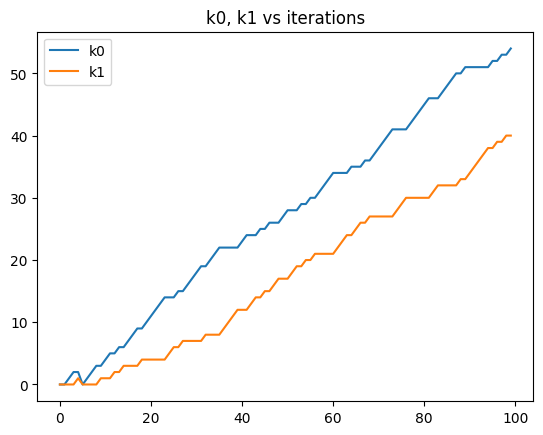

In [27]:
plt.plot(k0_hist)
plt.plot(k1_hist)
plt.legend(['k0', 'k1'])
plt.title("k0, k1 vs iterations")

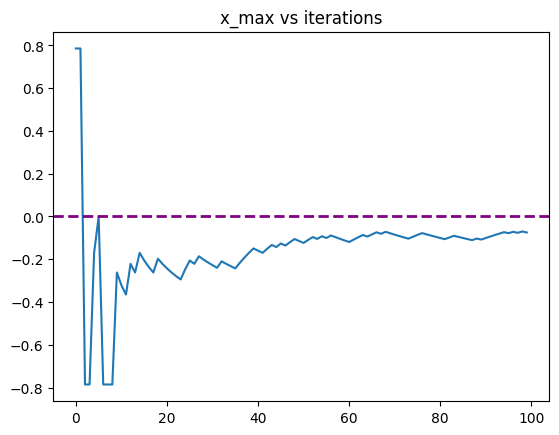

In [28]:
plt.plot(x_max_hist)
plt.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
plt.title("x_max vs iterations");

## Heisenberg chain model

In [29]:
L = 3

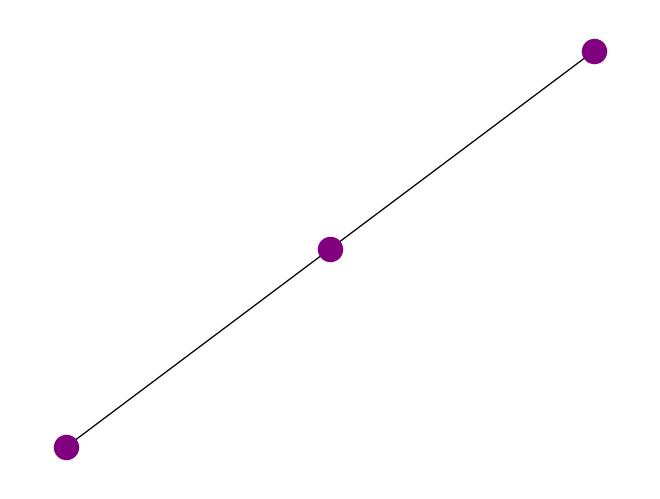

In [30]:
# Kagome unit cell
num_sites = L
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [ (i, i+1, t) for i in range(L-1)]

# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

In [31]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'YYI', 'IYY', 'XXI', 'IXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [32]:
# find the eigenvalue
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(ham)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4).real
gs_energy

-4.0

In [33]:
ops = []
coeffs = []

ham_ops = []
ham_coeffs = []

for op in ham:
    pauli_string = op.primitive.paulis[0]
    pauli_string = pauli_string.__str__()
    pauli_coeff = op.primitive.coeffs[0]
    
    ops.append(qml.pauli.string_to_pauli_word(pauli_string + 'Y'))
    ham_ops.append(qml.pauli.string_to_pauli_word(pauli_string)@qml.Identity(L))
    
    coeffs.append(pauli_coeff.real)
    ham_coeffs.append(pauli_coeff)

H = qml.Hamiltonian(coeffs, ops)

ham_matrix = qml.Hamiltonian(ham_coeffs, ham_ops).sparse_matrix().todense()
    
def ham_heisenberg(t):
    qml.ApproxTimeEvolution(H, t, 1)

In [34]:
print(H)

  (1.0) [Z0 Z1 Y3]
+ (1.0) [Z1 Z2 Y3]
+ (1.0) [Y0 Y1 Y3]
+ (1.0) [Y1 Y2 Y3]
+ (1.0) [X0 X1 Y3]
+ (1.0) [X1 X2 Y3]


In [36]:
ham_ops

[PauliZ(wires=[0]) @ PauliZ(wires=[1]) @ Identity(wires=[3]),
 PauliZ(wires=[1]) @ PauliZ(wires=[2]) @ Identity(wires=[3]),
 PauliY(wires=[0]) @ PauliY(wires=[1]) @ Identity(wires=[3]),
 PauliY(wires=[1]) @ PauliY(wires=[2]) @ Identity(wires=[3]),
 PauliX(wires=[0]) @ PauliX(wires=[1]) @ Identity(wires=[3]),
 PauliX(wires=[1]) @ PauliX(wires=[2]) @ Identity(wires=[3])]

In [37]:
ham_matrix.shape

(16, 16)

In [80]:
dev = qml.device("lightning.qubit", wires= L + 1)

@qjit
@qml.qnode(dev)
def circuit(k0, k1, t, Eth, max_iter, params, num_qubits, meas, k0_hist, k1_hist, x_max_hist):

    def loop(i, x, Eth, kk0, kk1, params, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist):
        qml.Hadamard(num_qubits)
        ham_heisenberg(x)
        m1 = 0 + measure_and_reset(num_qubits)
        
        a = m1 == 0
        b = m1 == 1
       
        temp_k0 = kk0 + a
        temp_k1 = kk1 + b
        val_0 = (temp_k1 - temp_k0)/(temp_k0 + temp_k1)
        x_max_0 = 0.5*jnp.arcsin(val_0)
        
        pred = x_max_0 < x*Eth
        c0, c1, b0, b1 = conditional_update_for_counters(pred, m1)
        
        kk0 = b0*kk0 + c0
        kk1 = b1*kk1 + c1
        val_1 = (kk1 - kk0)/(kk0 + kk1 + 0.01)
        x_max_1 = 0.5*jnp.arcsin(val_1)
                
        syndrome = x_max_1 >= x*Eth
        conditional_parameterized_unitary(syndrome, params, num_qubits)
        
        max_iter = 200
        additions = jnp.identity(max_iter)*m1
        meas = meas + additions[i]
        
        additions = jnp.identity(max_iter)*kk0
        kk0_hist = kk0_hist + additions[i]
        
        additions = jnp.identity(max_iter)*kk1
        kk1_hist = kk1_hist + additions[i]
        
        additions = jnp.identity(max_iter)*x_max_0
        x_max_hist = x_max_hist + additions[i]
        
        return x, Eth, kk0, kk1, params, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist

    # apply the while loop
    final_res = for_loop(0, max_iter, 1)(loop)(t, Eth, k0, k1, params, 
                                             num_qubits, meas, k0_hist, k1_hist, x_max_hist)

    return qml.state(), final_res

max_iter = 200
epsilon = 0.12
Eth = -0.5
k0 = 0
k1 = 0
num_qubits = L

# intermediate values
meas = np.zeros(max_iter)
k0_hist = np.zeros(max_iter)
k1_hist = np.zeros(max_iter)
x_max_hist = np.zeros(max_iter)
params = np.random.uniform(size=(num_qubits, 3))

res = circuit(k0, k1, epsilon, Eth, max_iter, params, num_qubits, meas, k0_hist, k1_hist, x_max_hist)
state = res[0]
meas, k0_hist, k1_hist, x_max_hist = res[7:]

temp_state = np.round(state,2)
print('state real:', temp_state.real)
print('state imag:', temp_state.imag)

state real: [ 0.02  0.   -0.03  0.    0.08  0.    0.05  0.   -0.03  0.   -0.15  0.
  0.05  0.   -0.01  0.  ]
state imag: [-0.04  0.   -0.29  0.    0.83  0.   -0.1   0.   -0.29  0.    0.29  0.
 -0.1   0.   -0.11  0.  ]


In [81]:
computed_energy = np.dot(np.conjugate(state), ham_matrix@state).real
print('Computed ground state energy:', computed_energy)

Computed ground state energy: -3.764665675854706


In [82]:
num_ones = int(np.sum(meas))
num_zeros = max_iter - num_ones
print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 50
Number of zeros: 150


Text(0.5, 1.0, 'k0, k1 vs iterations')

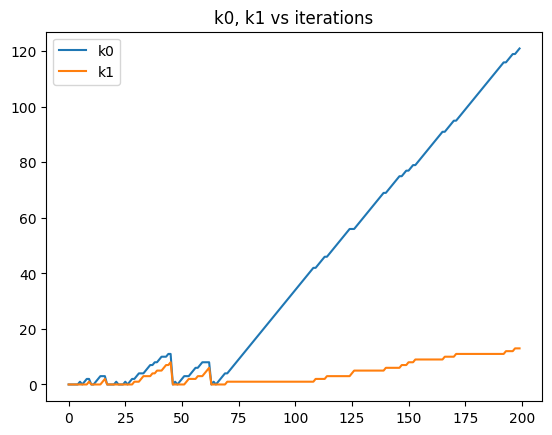

In [83]:
plt.plot(k0_hist)
plt.plot(k1_hist)
plt.legend(['k0', 'k1'])
plt.title("k0, k1 vs iterations")

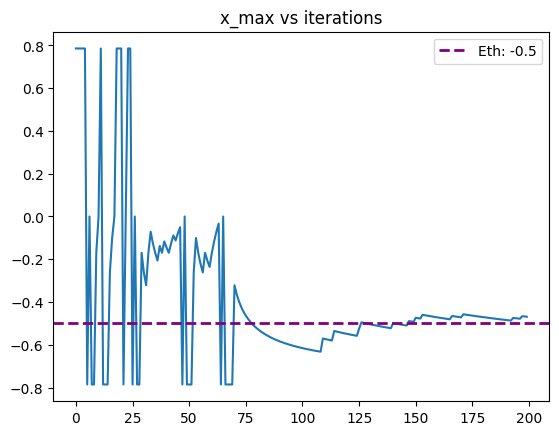

In [84]:
plt.plot(x_max_hist)
plt.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
plt.title("x_max vs iterations")
plt.legend()
plt.show()

## Transverse field ising model

In [85]:
lmbd = 1.0
L = 5

In [86]:
ops = []
coeffs = []

id_op = ['I']*L

for i in range(L):
    temp_op = id_op.copy()
    temp_op[i] = 'X'
    ops.append(''.join(temp_op))
    coeffs.append(lmbd)

for i in range(L-1):
    temp_op = id_op.copy()
    temp_op[i] = 'Z'
    temp_op[i+1] = 'Z'
    ops.append(''.join(temp_op))
    coeffs.append(1.0)

ham = PauliSumOp(SparsePauliOp(ops, coeffs))

# find the eigenvalue
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(ham)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4).real
gs_energy

-6.0267

In [87]:
ops = []
coeffs = []

ham_ops = []
ham_coeffs = []

for i in range(L):
    ops.append(qml.PauliX(i)@qml.PauliY(L))
    ham_ops.append(qml.PauliX(i)@qml.Identity(L))
    coeffs.append(lmbd)
    ham_coeffs.append(lmbd)

for i in range(L-1):
    ops.append(qml.PauliZ(i)@qml.PauliZ(i+1)@qml.PauliY(L))
    ham_ops.append(qml.PauliZ(i)@qml.PauliZ(i+1)@qml.Identity(L))
    coeffs.append(1.0)
    ham_coeffs.append(1.0)

H_tfim = qml.Hamiltonian(coeffs, ops)

ham_matrix = qml.Hamiltonian(ham_coeffs, ham_ops).sparse_matrix().todense()
    
def ham_tfim(t):
    qml.ApproxTimeEvolution(H_tfim, t, 1)

In [88]:
print(H_tfim)

  (1.0) [X0 Y5]
+ (1.0) [X1 Y5]
+ (1.0) [X2 Y5]
+ (1.0) [X3 Y5]
+ (1.0) [X4 Y5]
+ (1.0) [Z0 Z1 Y5]
+ (1.0) [Z1 Z2 Y5]
+ (1.0) [Z2 Z3 Y5]
+ (1.0) [Z3 Z4 Y5]


In [89]:
ham_ops

[PauliX(wires=[0]) @ Identity(wires=[5]),
 PauliX(wires=[1]) @ Identity(wires=[5]),
 PauliX(wires=[2]) @ Identity(wires=[5]),
 PauliX(wires=[3]) @ Identity(wires=[5]),
 PauliX(wires=[4]) @ Identity(wires=[5]),
 PauliZ(wires=[0]) @ PauliZ(wires=[1]) @ Identity(wires=[5]),
 PauliZ(wires=[1]) @ PauliZ(wires=[2]) @ Identity(wires=[5]),
 PauliZ(wires=[2]) @ PauliZ(wires=[3]) @ Identity(wires=[5]),
 PauliZ(wires=[3]) @ PauliZ(wires=[4]) @ Identity(wires=[5])]

In [90]:
ham_matrix.shape

(64, 64)

In [101]:
dev = qml.device("lightning.qubit", wires= L + 1)

@qjit
@qml.qnode(dev)
def circuit(k0, k1, t, Eth, max_iter, params, num_qubits, meas, k0_hist, k1_hist, x_max_hist):

    def loop(i, x, Eth, kk0, kk1, params, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist):
        qml.Hadamard(num_qubits)
        ham_tfim(x)
        m1 = 0 + measure_and_reset(num_qubits)
        
        a = m1 == 0
        b = m1 == 1
       
        temp_k0 = kk0 + a
        temp_k1 = kk1 + b
        val_0 = (temp_k1 - temp_k0)/(temp_k0 + temp_k1)
        x_max_0 = 0.5*jnp.arcsin(val_0)
        
        pred = x_max_0 < x*Eth
        c0, c1, b0, b1 = conditional_update_for_counters(pred, m1)
        
        kk0 = b0*kk0 + c0
        kk1 = b1*kk1 + c1
        val_1 = (kk1 - kk0)/(kk0 + kk1 + 0.01)
        x_max_1 = 0.5*jnp.arcsin(val_1)
                
        syndrome = x_max_1 >= x*Eth
        conditional_parameterized_unitary(syndrome, params, num_qubits)
        
        max_iter = 200
        additions = jnp.identity(max_iter)*m1
        meas = meas + additions[i]
        
        additions = jnp.identity(max_iter)*kk0
        kk0_hist = kk0_hist + additions[i]
        
        additions = jnp.identity(max_iter)*kk1
        kk1_hist = kk1_hist + additions[i]
        
        additions = jnp.identity(max_iter)*x_max_0
        x_max_hist = x_max_hist + additions[i]
        
        return x, Eth, kk0, kk1, params, num_qubits, meas, kk0_hist, kk1_hist, x_max_hist

    # apply the while loop
    final_res = for_loop(0, max_iter, 1)(loop)(t, Eth, k0, k1, params, 
                                             num_qubits, meas, k0_hist, k1_hist, x_max_hist)

    return qml.state(), final_res

max_iter = 200
epsilon = 0.12
Eth = -0.4
k0 = 0
k1 = 0
num_qubits = L

# intermediate values
meas = np.zeros(max_iter)
k0_hist = np.zeros(max_iter)
k1_hist = np.zeros(max_iter)
x_max_hist = np.zeros(max_iter)
params = np.random.uniform(size=(num_qubits, 3))

res = circuit(k0, k1, epsilon, Eth, max_iter, params, num_qubits, meas, k0_hist, k1_hist, x_max_hist)
state = res[0]
meas, k0_hist, k1_hist, x_max_hist = res[7:]

temp_state = np.round(state,2)
print('state real:', temp_state.real)
print('state imag:', temp_state.imag)

state real: [ 0.01  0.    0.04  0.   -0.02  0.   -0.21  0.   -0.27  0.    0.04  0.
 -0.05  0.    0.13  0.    0.07  0.    0.29  0.    0.12  0.    0.14  0.
 -0.01  0.    0.16  0.    0.02  0.   -0.06  0.    0.13  0.   -0.01  0.
  0.15  0.   -0.09  0.   -0.15  0.   -0.1   0.   -0.    0.   -0.1   0.
 -0.2   0.    0.01  0.    0.15  0.    0.1   0.   -0.02  0.   -0.06  0.
  0.13  0.   -0.06  0.  ]
state imag: [ 0.01  0.    0.02  0.   -0.1   0.   -0.16  0.   -0.08  0.    0.24  0.
 -0.05  0.    0.27  0.    0.09  0.    0.1   0.    0.06  0.   -0.08  0.
 -0.01  0.    0.11  0.   -0.    0.   -0.17  0.    0.06  0.   -0.01  0.
  0.01  0.   -0.13  0.   -0.27  0.   -0.06  0.   -0.15  0.   -0.09  0.
  0.02  0.    0.05  0.    0.26  0.    0.09  0.   -0.17  0.   -0.05  0.
  0.2   0.   -0.01  0.  ]


In [102]:
computed_energy = np.dot(np.conjugate(state), ham_matrix@state).real
print('Computed ground state energy:', computed_energy)

Computed ground state energy: 0.2931999898378529


In [103]:
num_ones = int(np.sum(meas))
num_zeros = max_iter - num_ones
print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 83
Number of zeros: 117


Text(0.5, 1.0, 'k0, k1 vs iterations')

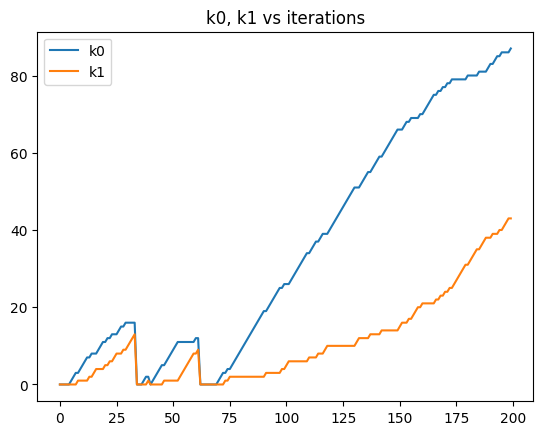

In [104]:
plt.plot(k0_hist)
plt.plot(k1_hist)
plt.legend(['k0', 'k1'])
plt.title("k0, k1 vs iterations")

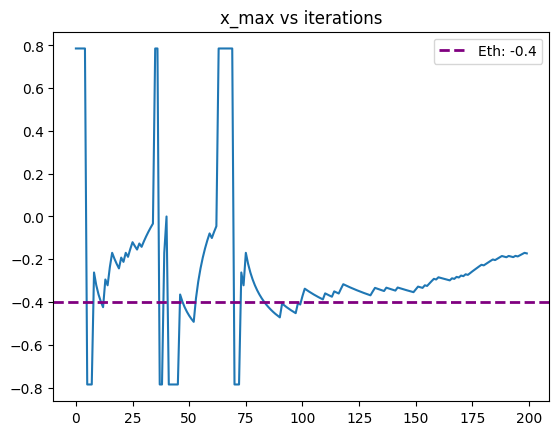

In [105]:
plt.plot(x_max_hist)
plt.axhline(y=Eth, color="purple", ls="--", lw=2, label=f"Eth: {Eth}")
plt.title("x_max vs iterations")
plt.legend()
plt.show()